In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data_folder = './results'

In [16]:
task_name = 'phase_retrival'
data_list = ['phase_data_10_60', 'phase_data_10_80', 'phase_data_10_100',
             'phase_data_15_80', 'phase_data_15_100', 'phase_data_30_180']
policy_list = ["standard","line_search","icml","backtracking","scopt"]
policy_labels= {"standard": 'Standard',
                "icml": 'Ver1',
                "backtracking": 'Ver2',
                "scopt": 'PN',
                "line_search": 'line_search'}
policy_colors = {"standard": 'C0',
                 "line_search": 'C1',
                 "icml": 'C2',
                 "backtracking": 'C3',
                 "scopt": 'C5'}
results = dict()


In [4]:
f_optim_values, error_hist_data, time_hist_data = {}, {}, {}
f_vals_data = {}

# calculate relative errors and save it (with time data)
for data_name in data_list:
    file_path = os.path.join(data_folder, task_name, data_name + '.pckl')
    with open(file_path, 'rb') as f:
        data_results =  pickle.load(f)
    data_results = data_results[data_name]
    f_min = min([data_results[policy]['Q_hist'][-1] for policy in data_results.keys()])
    f_optim_values[data_name] = f_min
    for policy in data_results.keys():
        errors = [abs(f_val - f_min) / abs(f_min) for f_val in data_results[policy]['Q_hist']]
        if policy not in error_hist_data.keys():
            error_hist_data[policy] = {}
            time_hist_data[policy] = {}
            f_vals_data[policy] = {}
        error_hist_data[policy][data_name] = np.array(errors)
        time_hist_data[policy][data_name] = np.array(data_results[policy]['time_hist'])
        f_vals_data[policy][data_name] = np.array(data_results[policy]['Q_hist'])

In [6]:
error_hist_data['standard']['phase_data_10_60']

array([7.94499196e-01, 5.27929885e-01, 2.00150414e-01, ...,
       1.43932612e-09, 1.51503782e-09, 1.51503782e-09])

## Problem info

In [22]:
error_thr = 1e-5

for i in range(len(policy_list)):
    policy = policy_list[i]
    policy_label = policy_labels[policy]
    for data_name in data_list:
        error_hist = np.array(error_hist_data[policy][data_name])
        if any(error_hist < error_thr):
            min_iters_qty = np.argmax(error_hist < error_thr)
        else:
            min_iters_qty = len(error_hist) - 1        
        min_time_qty = sum(time_hist_data[policy][data_name][:min_iters_qty])
        error = error_hist_data[policy][data_name][min_iters_qty]
        func_val = f_vals_data[policy][data_name][min_iters_qty]

        print(f'{data_name}, {policy}: {min_iters_qty} iters, {min_time_qty:.2f} time, error={error:.2e} f={func_val:.2f}')
    print()

phase_data_10_60, standard: 546 iters, 0.72 time, error=9.99e-06 f=-3735.52
phase_data_10_80, standard: 515 iters, 0.90 time, error=9.88e-06 f=-9546.68
phase_data_10_100, standard: 521 iters, 1.25 time, error=9.86e-06 f=-5379.72
phase_data_15_80, standard: 539 iters, 1.03 time, error=9.91e-06 f=-11979.44
phase_data_15_100, standard: 530 iters, 1.27 time, error=9.83e-06 f=-6312.01
phase_data_30_180, standard: 763 iters, 5.07 time, error=9.99e-06 f=-34982.21

phase_data_10_60, line_search: 9849 iters, 342.12 time, error=1.00e-05 f=-3735.52
phase_data_10_80, line_search: 2528 iters, 116.34 time, error=1.00e-05 f=-9546.68
phase_data_10_100, line_search: 7605 iters, 463.40 time, error=1.00e-05 f=-5379.72
phase_data_15_80, line_search: 9960 iters, 543.00 time, error=1.00e-05 f=-11979.44
phase_data_15_100, line_search: 11485 iters, 778.12 time, error=1.00e-05 f=-6312.01
phase_data_30_180, line_search: 13143 iters, 2776.17 time, error=1.00e-05 f=-34982.21

phase_data_10_60, icml: 10332 iters, 

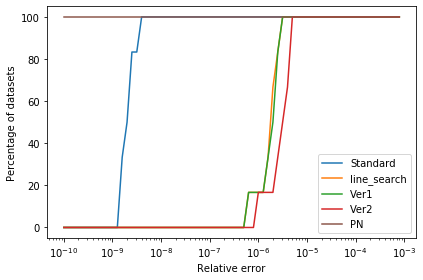

In [17]:
#dataset percentage plot
policy_percentage_plot = {}
for j in range(len(policy_list)):
    policy = policy_list[j]
    policy_label = policy_labels[policy]
    error_range = 10.0**np.arange(-10, -3, 0.1)
    achieved_error_data_qty = []
    for error_val in error_range:
        curr_error_achieved_qty = 0
        for error_hist in error_hist_data[policy].values():
            if (error_hist[-1] < error_val):
                curr_error_achieved_qty += 1
        achieved_error_data_qty.append(curr_error_achieved_qty)
    policy_percentage_plot[policy] = achieved_error_data_qty
    #print(policy,policy_percentage_plot[policy])
for i in range(len(policy_percentage_plot)):
    policy = policy_list[i]
    policy_label = policy_labels[policy]
    plt.plot(error_range, np.array(policy_percentage_plot[policy]) / len(data_list) * 100, label=policy_label, c=policy_colors[policy])

plt.legend()
plt.xscale('log')
plt.xlabel('Relative error')
plt.ylabel(('Percentage of datasets'))
plt.tight_layout()
plt.savefig('./pics/phase_retrival/dataset_proportion_plot.png')
plt.show()

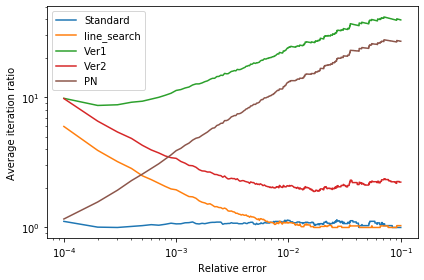

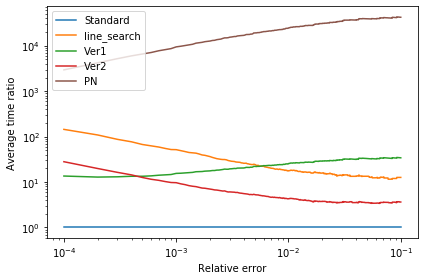

In [18]:
#average ratio iter plot
minimal_iter_per_algo = {}
minimal_time_per_algo = {}

for policy in error_hist_data.keys():
    error_range = np.arange(1e-12, 1e-1, 1e-4)
    for data_name, error_hist in error_hist_data[policy].items():
        current_data_minimal_iters = []
        current_data_minimal_times = []
        for error_val in error_range:
            if any(error_hist < error_val):
                # find index of first error that lower than threshold (+1 since numeration starts from 0)
                iter_index = np.argmax(error_hist < error_val) + 1
                current_data_minimal_iters.append(iter_index)
                current_data_minimal_times.append(np.sum(time_hist_data[policy][data_name][:iter_index]))
            else:
                current_data_minimal_iters.append(np.nan)#len(error_hist))
                current_data_minimal_times.append(np.nan)#np.sum(time_hist_data[policy][data_name]))
        if policy not in minimal_iter_per_algo.keys():
            minimal_iter_per_algo[policy] = {}
            minimal_time_per_algo[policy] = {}
        minimal_iter_per_algo[policy][data_name] = current_data_minimal_iters
        minimal_time_per_algo[policy][data_name] = current_data_minimal_times

ratio_of_iter_per_algo = {}
ratio_of_time_per_algo = {}

for data_name in data_list:
    for i in range(len(error_range)):
        iters_over_policies = [minimal_iter_per_algo[policy][data_name][i] for policy in policy_list]
        times_over_policies = [minimal_time_per_algo[policy][data_name][i] for policy in policy_list]
        minimal_iter_val = min(iters_over_policies)
        minimal_time_val = min(times_over_policies)
        for policy in policy_list:
            if policy not in ratio_of_iter_per_algo.keys():
                ratio_of_iter_per_algo[policy] = {}
                ratio_of_time_per_algo[policy] = {}
            if data_name not in ratio_of_iter_per_algo[policy].keys():
                ratio_of_iter_per_algo[policy][data_name] = []
                ratio_of_time_per_algo[policy][data_name] = []
            ratio_of_iter_per_algo[policy][data_name].append(minimal_iter_per_algo[policy][data_name][i] / minimal_iter_val)
            ratio_of_time_per_algo[policy][data_name].append(minimal_time_per_algo[policy][data_name][i] / minimal_time_val)

for j in range(len(policy_list)):
    policy = policy_list[j]
    policy_label = policy_labels[policy]
    policy_avg_ratios = []
    for i in range(len(error_range)):
        policy_avg_ratios.append(np.mean([ratio_of_iter_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_ratios, label=policy_label, c=policy_colors[policy])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average iteration ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/phase_retrival/avg_iter_plot.png')
plt.show()

for j in range(len(policy_list)):
    policy = policy_list[j]
    policy_label = policy_labels[policy]
    policy_avg_time_ratios = []
    for i in range(len(error_range)):
        policy_avg_time_ratios.append(np.mean([ratio_of_time_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_time_ratios, label=policy_label, c=policy_colors[policy])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average time ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/phase_retrival/avg_time_plot.png')
plt.show()

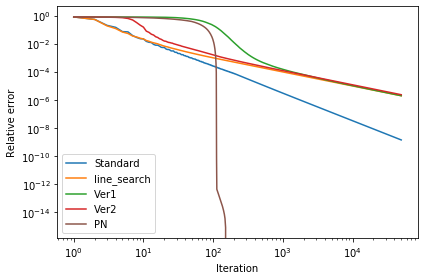

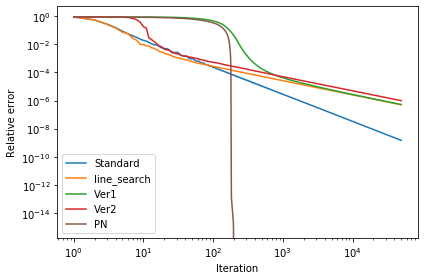

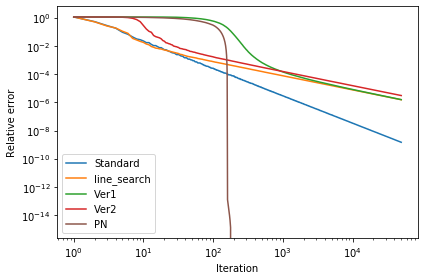

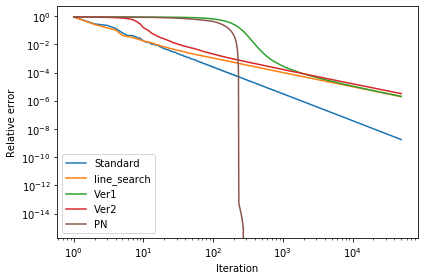

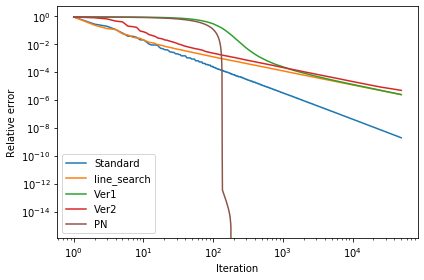

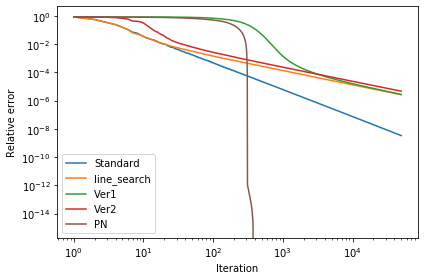

In [20]:
for data in data_list:
    for i in range(len(policy_list)):
        policy=policy_list[i]
        policy_label=policy_labels[policy]
        series = pd.Series(error_hist_data[policy][data]) 
        plt.plot(range(1,len(error_hist_data[policy][data])+1),series.cummin(), label=policy_label, c=policy_colors[policy])
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Relative error')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join('./pics/phase_retrival', data + 'error_vs_iter.png'))
    plt.show()

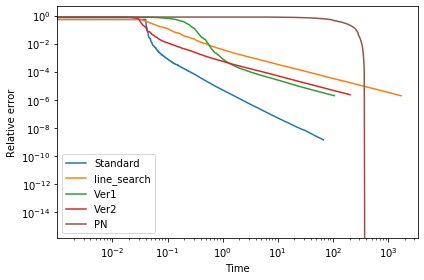

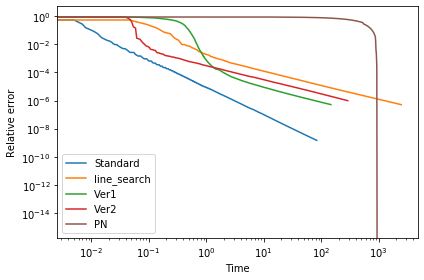

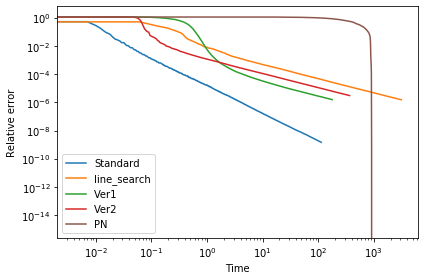

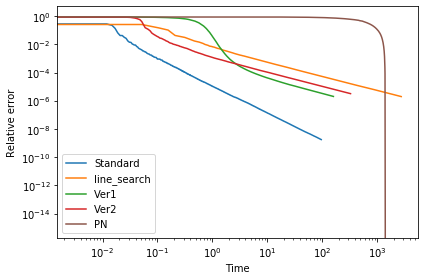

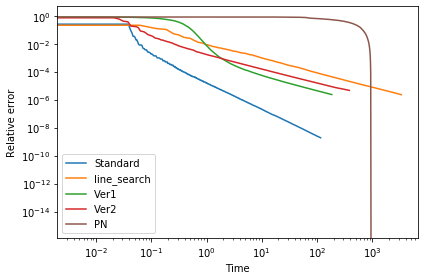

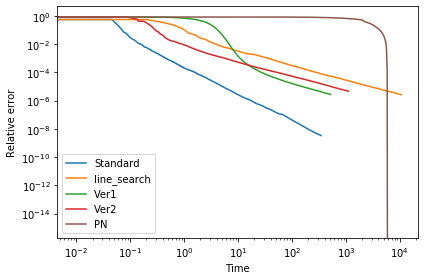

In [21]:
for data in data_list:
    for i in range(len(policy_list)):
        policy=policy_list[i]
        policy_label=policy_labels[policy]
        series = pd.Series(error_hist_data[policy][data]) 
        plt.plot(np.cumsum(time_hist_data[policy][data]),series.cummin(), label=policy_label, c=policy_colors[policy])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Relative error')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join('./pics/phase_retrival', data + 'error_vs_time.png'))
    plt.show()